# Sumatra export

In [1]:
#This cell will increase the width of the cells to fit more of the screen
#adjust the precentage value as you wish
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import numpy as np
import sympy
import fipy as fp
from fipy import numerix as nmx
import matplotlib.pyplot as plt
import os
import json
import sys

In [6]:
os.getcwd()

'/data/aem1/new1a/cluster-sumatra-sims'

First we need to create a json file for sumatra to read parameters from

In [ ]:

#record the volume integral of the free energy 
# equivalent to the average value of the free energy for any cell,
# multiplied by the number of cells and the area of each cell
# (since this is a 2D domain)        
# bulk free energy density
def f_0(c):
    return rho_s*((c - c_alpha)**2)*((c_beta-c)**2)
def f_0_var(c_var):
    return 2*rho_s*((c_alpha - c_var)**2 + 4*(c_alpha - c_var)*(c_beta - c_var) + (c_beta - c_var)**2)
# free energy
def f(c):
    return (f_0(c)+ .5*kappa*(c.grad.mag)**2)

The next block will create a python file in your directory to run the 1a, 1b, 1c, problems from https://pages.nist.gov/chimad-phase-field/hackathon1/

In [ ]:
%%writefile fipy_hackathon_1.py
        
#read in the parameter file
jsonfile = sys.argv[1] 
if jsonfile:
    with open(jsonfile, 'rb') as ff:
        params = json.load(ff)
        
else:
    print "***No parameter file found! ***"
    
print 'my params:', params

#extract the parameters
N = params.get('N', 20)  
total_steps = params.get('steps', 2)
sumatra_label = params.get('sumatra_label', '')
total_sweeps = params.get ('sweeps', 2)
duration = params.get('duration', 500)
problem = params.get('problem', 'a')
tolerance = params.get('tolerance',0.1)
solverParam = params.get('solver', 'PCG')


c, rho_s, c_alpha, c_beta = sympy.symbols("c_var rho_s c_alpha c_beta")
f_0 = rho_s * (c - c_alpha)**2 * (c_beta - c)**2

sympy.diff(f_0, c, 2)

# command format:


if (problem == "a"):
    print "Creating mesh for problem a"
    mesh = fp.PeriodicGrid2D(nx=N, ny=N, dx=200.0/float(N), dy=200.0/float(N))
    
elif (problem == "b"):
    print "Creating mesh for problem b"
    mesh = fp.Grid2D(nx=N, ny=N, dx=200.0/float(N), dy=200.0/float(N))
    
elif (problem == "c"):
    print "Creating mesh for problem c"
    Lx=20.
    Ly=100.0
    dxT=100./N
    dyT=100./N
    nxT=N
    nyT=N/5
    mesh = fp.Grid2D(nx=N / 5, ny=N, dx=20./(N/5), dy=100./N) + (fp.Grid2D(nx=N, ny=N / 5, dx=100./N, dy=20./(N/5)) + [[-40],[100]])
#    mesh = fp.Grid2D(dx=0.5, dy=0.5, nx=40, ny=200) + (fp.Grid2D(dx=0.5, dy=0.5, nx=200, ny=40) + [[-40],[100]])
    mesh = fp.Grid2D(Lx=20., Ly=100.0, nx=N / 5, ny=N) + (fp.Grid2D(Ly=20.0, Lx=100.0, nx=N, ny=N / 5) + [[-40],[100]])
       
elif (problem == "d"):
    print "Creating mesh for problem d"
    r = float(sys.argv[2])
    numCellsDesired = int(sys.argv[3])
    epsilon = 0.05
    cellSize = 16 * np.pi * r**2 / (nmx.sqrt(3.) * numCellsDesired)
    cellSize = nmx.sqrt(cellSize)
    
    substring1 = '''
    radius = {0};
    cellSize = {1};
    '''.format(r, round(cellSize, 6))

    mesh = fp.Gmsh2DIn3DSpace(substring1 + '''

    // create inner 1/8 shell
    Point(1) = {0, 0, 0, cellSize};
    Point(2) = {-radius, 0, 0, cellSize};
    Point(3) = {0, radius, 0, cellSize};
    Point(4) = {0, 0, radius, cellSize};
    Circle(1) = {2, 1, 3};
    Circle(2) = {4, 1, 2};
    Circle(3) = {4, 1, 3};
    Line Loop(1) = {1, -3, 2};
    Ruled Surface(1) = {1};

    // create remaining 7/8 inner shells
    t1[] = Rotate {{0,0,1},{0,0,0},Pi/2} {Duplicata{Surface{1};}};
    t2[] = Rotate {{0,0,1},{0,0,0},Pi} {Duplicata{Surface{1};}};
    t3[] = Rotate {{0,0,1},{0,0,0},Pi*3/2} {Duplicata{Surface{1};}};
    t4[] = Rotate {{0,1,0},{0,0,0},-Pi/2} {Duplicata{Surface{1};}};
    t5[] = Rotate {{0,0,1},{0,0,0},Pi/2} {Duplicata{Surface{t4[0]};}};
    t6[] = Rotate {{0,0,1},{0,0,0},Pi} {Duplicata{Surface{t4[0]};}};
    t7[] = Rotate {{0,0,1},{0,0,0},Pi*3/2} {Duplicata{Surface{t4[0]};}};

    // create entire inner and outer shell
    Surface Loop(100)={1, t1[0],t2[0],t3[0],t7[0],t4[0],t5[0],t6[0]};
    ''', order=2.0).extrude(extrudeFunc=lambda r: 1.01*r)

c_alpha = 0.3
c_beta = 0.7
kappa = 2.0
M = 5.0
c_0 = 0.5
epsilon = 0.01
rho_s = 5.0



# solution variable
c_var = fp.CellVariable(mesh=mesh, name=r"$c$", hasOld=True)

# array of sample c-values: used in f versus c plot
vals = np.linspace(-.1, 1.1, 1000)

if (problem == 'a' or 'b' or 'c'):
    # 2D mesh coordinates
    x, y = np.array(mesh.x), np.array(mesh.y)
    # initial value for square and T domains
    c_var[:] = c_0 + epsilon * (np.cos(0.105 * x) * np.cos(0.11 * y) + (np.cos(0.13 * x) * np.cos(0.087 * y))**2 + np.cos(0.025 * x - 0.15 * y) * np.cos(0.07 * x - 0.02 * y))
if (problem == 'd'):
    print "number of cells: " , mesh.numberOfCells
    # 3D mesh coordinates
    x, y, z = np.array(mesh.x), np.array(mesh.y), np.array(mesh.z)
    
    # convert from rectangular to spherical coordinates
    theta = fp.CellVariable(name=r"$\theta$", mesh=mesh)
    theta = nmx.arctan2(z, nmx.sqrt(x**2 + y**2))
    phi = fp.CellVariable(name=r"$\phi$", mesh=mesh)
    phi = nmx.arctan2(y, x)
     
    # initial value for spherical domain
    c_var[:]  = c_0 + epsilon * ((np.cos(8*theta))*(np.cos(15*phi)) + ((np.cos(12*theta))*(np.cos(10*phi)))**2 + ((np.cos(2.5*theta - 1.5*phi))*(np.cos(7*theta - 2*phi))))
    

#Method for making sure we save .mpz.npz at specified dump_times
def calc_dt(elapsed_time, dt, dt_old, dump_to_file, dump_times, filename):
    if dump_to_file: #if this is true, we have alreay saved the necessary .mpz.npz file
        dt = dt_old #reset back to normal dt
        dt = dt * 1.1 #continue as normal
        dump_to_file = False
        # filename = '1a_{0}_step{1}_data_time-{2:.2f}.npz'.format(N, str(steps).rjust(6, '0'), elapsed+dt)
    else:
        dt_old = dt
        dt = dt * 1.1
        # import ipdb; ipdb.set_trace()

        if len(dump_times) > 0:
            if (elapsed_time + dt) >= dump_times[0]:
                dt = dump_times[0] - elapsed_time
                dump_to_file = True
                
                #dump_time files will have .mpz.npz extension
                # filename = '1a_{0}_step{1}_data_time-{2:.2f}.mpz.npz'.format(N, str(steps).rjust(6, '0'), elapsed+dt)
                del dump_times[0]

    return dt, dt_old, dump_times, dump_to_file, filename
    
# save elapsed time and free energy at each data point
time_data = []
cvar_data = []
f_data = []
# checks whether a folder for the pickles from this simulation exists
# if not, creates one in the home directory
filepath = os.path.join(os.getcwd(), sumatra_label)


# solver equation    
eqn = fp.TransientTerm(coeff=1.) == fp.DiffusionTerm(M * f_0_var(c_var)) - fp.DiffusionTerm((M, kappa))

elapsed = 0.0
steps = 0
dt = 0.01
dump_times = [1.0, 5.0, 10.0, 20.0, 100.0, 200, 500, 1000, 2000, 3000, 10000] #the specific elapsed times when we want to save out .mpz.npz files
dt_old = dt
dump_to_file = False
filename = 'Andrey Moskalenko'


c_var.updateOld()
if (solverParam = "PCG"):
    from fipy.solvers.pysparse import LinearPCGSolver as Solver
if (solverParam = "LU"):
    from fipy.solvers.pysparse import LinearLUSolver as Solver
solver = Solver()
print "Starting Solver."
while (steps <= total_steps) and elapsed <= duration:
    res0 = eqn.sweep(c_var, dt=dt, solver=solver)

    
    for sweeps in range(total_sweeps):
        res = eqn.sweep(c_var, dt=dt, solver=solver)
                    
    if res < res0 * tolerance:  
        # anything in this loop will only be executed every 10 steps
        if dump_to_file or (steps%10==0):
            print steps
            print elapsed 
            print "Saving data"
            if dump_to_file: filename = '1{3}_{0}_step{1}_data_time-{2:.2f}.mpz.npz'.format(N, str(steps).rjust(6, '0'), elapsed, problem)
            else: filename = '1{3}_{0}_step{1}_data_time-{2:.2f}.npz'.format(N, str(steps).rjust(6, '0'), elapsed, problem)
            if (problem == 'a') or (problem == 'b'):
                np.savez(os.path.join(filepath,filename),
                     c_var_array=np.array(c_var),
                     dt=dt,
                     elapsed=elapsed,
                     steps=steps,
                     dx=c_var.mesh.dx,
                     dy=c_var.mesh.dy,
                     nx=c_var.mesh.nx,
                     ny=c_var.mesh.ny,
                     sweeps = total_sweeps,
                     tolerance = tolerance)
            if (problem == 'c'):
                np.savez(os.path.join(filepath,filename),
                     c_var_array=np.array(c_var),
                     dt=dt,
                     elapsed=elapsed,
                     steps=steps,
                     dx=dxT,
                     dy=dyT,
                     nx=nxT,
                     ny=nyT,
                     sweeps = total_sweeps,
                     tolerance = tolerance)

                
            elif (problem == 'd'):
                print "saving for d!!"
                if dump_to_file: filename = '1d_{0}_step{1}_data_time-{2:.2f}.mpz.npz'.format(N, str(steps).rjust(6, '0'), elapsed)
                else: filename = '1d_{0}_step{1}_data_time-{2:.2f}.npz'.format(N, str(steps).rjust(6, '0'), elapsed)
                #save_data(elapsed, c_var, )

                np.savez(os.path.join(filepath,filename),
                     c_var_array=np.array(c_var),
                     dt=dt,
                     elapsed=elapsed,
                     steps=steps,
                     dx=c_var.mesh.dx,
                     dy=c_var.mesh.dy,
                     nx=c_var.mesh.nx,
                     ny=c_var.mesh.ny,
                     sweeps = total_sweeps,
                     tolerance = tolerance)

        dt, dt_old, dump_times, dump_to_file, filename = calc_dt(elapsed, dt, dt_old, dump_to_file, dump_times, filename)
        steps += 1
        elapsed += dt
        c_var.updateOld()
    else:
        dt *= 0.8
        c_var[:] = c_var.old

# simulation ends
print 'steps reached:', steps


Let's create the json parameter file

In [ ]:
def ParameterFile(N, steps, duration, sweeps, problem, tolerance, solver):
    
    params = {'N' : N,  'steps' : stp, 'sweeps' : sweeps, 'duration':duration, 'problem':problem, 'tolerance':tolerance, 'solver':solver}

    with open('params.json', 'w') as fp:
        json.dump(params, fp)
        

In [ ]:
ParameterFile(50, 200, 200, 2, 'a', 0.1, 'PCG')

# Create a Git Repository 


In this demo, I'm assuming that the working directory is a Git repository set up with

$ git init

gitaddfipytiming.py git ci -m "Add timing script."

Sumatra requires that the script is sitting in the a working copy of a repository.

# Configure Sumatra


Once the repository is setup, the Sumatra repository can be configured. Here we are using the serial launch mode.

In [ ]:
%%bash

\rm -rf .smt #removes any existing sumatra project
smt init smt-fipy-demo #chnage this name to whatever you want
smt configure --executable=python --main=fipy_hackathon_1.py
smt configure --launch_mode=serial
smt configure -g uuid
smt configure -c store-diff
smt configure --addlabel=parameters

Run the simulation using Sumatra

In [ ]:
#This command allows you to change the parameters from the params.json file to anything
#Sumatra creates a new json file when this happens, which contains the new specified parameters

!smt run params.json N=50 steps=200 sweeps=2 duration=200 problem="a" tolerance=0.1 solver="PCG"


once the simulation is done and Sumatra saves the record, we can export the simulation information

In [1]:
import pandas

#export the sumatra simulation record
!smt export  

#save the record into a blank variable called 'data'
#in your working Sumatra directory, there will be a .smt/ directory which stores all the records
with open('.smt/records_export.json') as ff:
    data = json.load(ff)
    
#save a back up file with a more readable format    
with open('record1.json', 'w') as record1:
    for entry in range(len(data)):
        record1.write(json.dumps(data[entry], sort_keys=True, indent=4, separators=(',', ': ')))
        
#create a dataframe with which we can now work with
df = pandas.DataFrame(data)  #df is now the sumatra dataframe

If you have run simulation in different directories and wish to also include their data with the simulations in your current directory, you can run "smt export" in that directory from the command line. Then open the "directorypath/.smt/records_export.json" file and save it as df2. Later on you can combine the two dataframe into one.

In [386]:
print df['label'] #to show the Sumatra labels of the simulations in the record

df #to see the whole dataframe

11980.8678899
----------------------------------------------------------------------------------------------------
2294ce8e0c73


# Extractor() : 

This method finds the simulations which have ".mpz.npz" files in their Data/ folder and gets all the information out of those files into a dataframe. 
First you create a dictionary and fill it with all the information from a single simulation, then add the dictionary to the dataframe as a single row.

Repeat in a loop for every simulation


In [ ]:
# p = str(df['datastore'][0]['parameters']['root'])
# p = p[:-13]
# print p
# datapath = os.path.join(p, '3ea82cfb13ea')
# mfile = glob.glob('{0}/*.mpz.npz'.format(datapath))

# # for mpzfile in mfile:
# fn = np.load(mfile[0])
# for item in fn:
#     print item, ' = ', fn[item]
        
# print mfile
dfPCG['label']

In [133]:
import glob
import os
import fipy as fp

###FREE ENERGY MATH
results = {}
c_alpha = 0.3
c_beta = 0.7
kappa = 2.0
# M = 5.0
# c_0 = 0.5
# epsilon = 0.01
rho_s = 5.0

#record the volume integral of the free energy 
# equivalent to the average value of the free energy for any cell,
# multiplied by the number of cells and the area of each cell
# (since this is a 2D domain)        
# bulk free energy density

def f_0(c):
    return rho_s*((c - c_alpha)**2)*((c_beta-c)**2)
# free energy
def f(c):
    return (f_0(c)+ .5*kappa*(c.grad.mag)**2)

#.mpz.npz are marker npz files which are saved at specific elapsed times. That way you can compare the concentration values for the same problem under different grid sizes etc.
#and every simulation saves the .mpz.npz files at exactly the same times
def extractor(labelz, Lx=200.):  
    rows = 0
    for label in labelz:
        dictt = {} #create a dictionary to fill in with simulation data
        dictt.update({'label':lable})
        output_filepath = str(df['datastore'][0]['parameters']['root'])
        output_filepath = p[:-13] #cuts off the sumatra label from the datapath
        datapath = os.path.join(output_filepath, lbl)
        mfiles = glob.glob('{0}/*.mpz.npz'.format(datapath)) #get the name of the mpz files with data we need

        #create the mesh for simulation associated with this label
        #this mesh will only work for problem 1a since it is the periodic mesh
        #this code requires an if statement to check for which problem was run in the simulation
        #and then create the corresponding mesh for the problem. The free energy calculation changes for the problems as well
        fn_0 = np.load(mfile[0]) #first file in the simulaition Data directory
        SimMesh = fp.PeriodicGrid2D(nx=fn_0['nx'], ny=fn_0['ny'], dx = Lx / fn_0['nx'], dy = Lx / fn_0['ny'])
        cvar_array = fn_0['c_var_array']
        c_var = fp.CellVariable(value = cvar_array, mesh = SimMesh)
        
        #Now we need to read each output file and add all the information from each file as a seprate row into the dataframe
        if len(mfiles)>=1:
            for mpzfile in mfiles:
                fn = np.load(mpzfile)
                for item in fn:
                    dictt.update({str(item):fn[item]}) #add every variable from the file into the dictionary
                
                #create blank columns for the dataframe to fill in later
                dictt.update({'L1':[]})
                dictt.update({'L2':[]})
                dictt.update({'Linf':[]})
                dictt.update({'real duration':[]})
                dictt.update({'memory usage':[]})
                
                #update the cell variable and append free energy to the dictionary
                cvar_array = fn['c_var_array']
                c_var[:] = cvar_array
                dx = c_var.mesh.dx #Lx / fn['nx']
                dy = c_var.mesh.dx #Lx / fn['ny']
                free_energy_cellVolAvg = np.mean(f(c_var))*SimMesh.numberOfCells*dx*dy
                dictt.update({'free energy at elapsed': free_energy_cellVolAvg }) 
                
                dfC.loc[rows]=dictt        
                rows+=1 #row iterator
    return dfC #dfC is a compact dataframe with all the information we need

#if you wish to combine another dataframe from a separte directory into this dfC dataframe,
#you can use the same extractor method, update the output_filepath, and begin the row iterator at the last row of dfC
#so rows=len(dfC) 

[]


Create the dataframe which we need to fill in with data

In [137]:
dfC = pandas.DataFrame(columns=['label','real duration', 'memory usage', 'steps','elapsed', 'nx', 'ny', 'solver', 'tolerance', 'free energy at elapsed', 'c_var_array', 'dt', 'dx', 'dy', 'sweeps', 'L1', 'L2', 'Linf'])


Get all the sumatra labels and call the extractor method on them

In [138]:
labels = df['label']
extractor(labels) 

,label,real duration,memory usage,steps,elapsed,nx,ny,solver,tolerance,free energy at elapsed,c_var_array,dt,dx,dy,sweeps,L1,L2,Linf
0,ea519a46fe59,[],[],26,1.016529,400,400,LU,0.1,318.858274,"[0.50689734786, 0.508564866228, 0.510109661285...",0.0165294056612,0.5,0.5,4,[],[],[]
1,ea519a46fe59,[],[],43,5.104952,400,400,LU,0.1,316.226758,"[0.513543344241, 0.517738202762, 0.52159939170...",0.104952481839,0.5,0.5,4,[],[],[]
2,ea519a46fe59,[],[],51,10.276795,400,400,LU,0.1,293.444885,"[0.533938310938, 0.541605671083, 0.54863730859...",0.276794734012,0.5,0.5,4,[],[],[]
3,ea519a46fe59,[],[],61,20.701200,400,400,LU,0.1,211.999820,"[0.536426936391, 0.53952984103, 0.542369290457...",0.93493318735,0.5,0.5,4,[],[],[]
4,ea519a46fe59,[],[],126,100.654310,400,400,LU,0.1,136.927738,"[0.489360703663, 0.482064909365, 0.47451228206...",0.654310002927,0.5,0.5,4,[],[],[]
5,ea519a46fe59,[],[],203,200.901822,400,400,LU,0.1,119.276024,"[0.425644652707, 0.417118093174, 0.40875055200...",0.901821981452,0.5,0.5,4,[],[],[]
6,a45690313727,[],[],26,1.016529,100,100,LU,0.1,318.843659,"[0.516982487929, 0.5227468515, 0.52091822422, ...",0.0165294056612,2.0,2.0,1,[],[],[]
7,a45690313727,[],[],43,5.104952,100,100,LU,0.1,316.143727,"[0.538724469778, 0.551849762143, 0.55002994639...",0.104952481839,2.0,2.0,1,[],[],[]
8,a45690313727,[],[],51,10.453190,100,100,LU,0.1,294.126580,"[0.58370926951, 0.601721802393, 0.601066378646...",0.45318970453,2.0,2.0,1,[],[],[]
9,a45690313727,[],[],70,20.008379,100,100,LU,0.1,207.933969,"[0.592711891262, 0.606596498292, 0.60525664413...",0.00837892317701,2.0,2.0,1,[],[],[]


If you have unwanted simulations in the dataframe, here is some example code on how to remove them.

In [141]:
#make a temporary dataframe which only includes simulatios with sweeps between 1 and 8
dfC_sweepTemp = dfC.query('(sweeps == 1) or (sweeps == 2) or (sweeps == 4) or (sweeps == 3) or (sweeps == 5) or (sweeps == 6) or (sweeps == 7) or (sweeps == 8)')
#Then you can also remove a specific simulation by it's sumatra label
dfC_sweepTemp2 = dfC_sweepTemp.query('(label != "509812ef5230")')

#you can also iterate through the rows and change the information in specific cells if needed.
for index, row in dfC_sweepTemp2.iterrows():

    #now fix the elapsed time for the newest simulation, elapsed is now saved properly so I have to adjust back
    if row['label'] == 'a45690313727' or row['label'] == 'ea519a46fe59':
        dfC_sweepTemp2.loc[index, 'elapsed'] = dfC_sweepTemp2.loc[index, 'elapsed'] - dfC_sweepTemp2.loc[index, 'dt'] #this is in case the elapsed times are saved wrong in the mpz.npz files for some simulations

    #you can find a specific point in a simulation by checking all the conditions at which it might be
    if row['label'] == 'ad4019c3836e' and row['steps'] == int(151) and row['sweeps'] == int(8) and row['solver'] == 'PCG':
        dfC_sweepTemp2.loc[index, 'elapsed'] = float(200.0) #set the elapsed time for the specific row to 200.0
        print 'Elapsed time for ', row['nx'], '-', row['sweeps'], ' is now ', dfC_sweepTemp2.loc[index, 'elapsed'] 
        
dfC_sweepTemp2

[array(1) array(2) array(3) array(4) array(5) array(6) array(7) array(8)
 array(15) array(31)]
Elapsed time for  400 - 4  is now  20.0
Elapsed time for  100 - 7  is now  200.0
Elapsed time for  400 - 4  is now  20.0
Elapsed time for  400 - 2  is now  500.0
Elapsed time for  100 - 8  is now  200.0


,label,real duration,memory usage,steps,elapsed,nx,ny,solver,tolerance,free energy at elapsed,c_var_array,dt,dx,dy,sweeps,L1,L2,Linf
0,ea519a46fe59,[],[],26,1,400,400,LU,0.1,318.858274,"[0.50689734786, 0.508564866228, 0.510109661285...",0.0165294056612,0.5,0.5,4,[],[],[]
1,ea519a46fe59,[],[],43,5,400,400,LU,0.1,316.226758,"[0.513543344241, 0.517738202762, 0.52159939170...",0.104952481839,0.5,0.5,4,[],[],[]
2,ea519a46fe59,[],[],51,10,400,400,LU,0.1,293.444885,"[0.533938310938, 0.541605671083, 0.54863730859...",0.276794734012,0.5,0.5,4,[],[],[]
3,ea519a46fe59,[],[],61,20,400,400,LU,0.1,211.999820,"[0.536426936391, 0.53952984103, 0.542369290457...",0.93493318735,0.5,0.5,4,[],[],[]
4,ea519a46fe59,[],[],126,100,400,400,LU,0.1,136.927738,"[0.489360703663, 0.482064909365, 0.47451228206...",0.654310002927,0.5,0.5,4,[],[],[]
5,ea519a46fe59,[],[],203,200,400,400,LU,0.1,119.276024,"[0.425644652707, 0.417118093174, 0.40875055200...",0.901821981452,0.5,0.5,4,[],[],[]
6,a45690313727,[],[],26,1,100,100,LU,0.1,318.843659,"[0.516982487929, 0.5227468515, 0.52091822422, ...",0.0165294056612,2.0,2.0,2,[],[],[]
7,a45690313727,[],[],43,5,100,100,LU,0.1,316.143727,"[0.538724469778, 0.551849762143, 0.55002994639...",0.104952481839,2.0,2.0,2,[],[],[]
8,a45690313727,[],[],51,10,100,100,LU,0.1,294.126580,"[0.58370926951, 0.601721802393, 0.601066378646...",0.45318970453,2.0,2.0,2,[],[],[]
9,a45690313727,[],[],70,20,100,100,LU,0.1,207.933969,"[0.592711891262, 0.606596498292, 0.60525664413...",0.00837892317701,2.0,2.0,2,[],[],[]


This command will show you the first 5 rows, adjust as needed if you wish to see specific rows in the dataframe

In [161]:
dfC_sweepTemp2.loc[0:5]

,label,real duration,memory usage,steps,elapsed,nx,ny,solver,tolerance,free energy at elapsed,c_var_array,dt,dx,dy,sweeps,L1,L2,Linf
123,abc377b4f395,201555,607.68,25,1,400,400,PCG,0.1,318.858274,"[0.506897350985, 0.508564868904, 0.51010966355...",0.0165294056612,0.5,0.5,8,5.43373e-06,4.64601e-08,3.31512e-09
124,abc377b4f395,201555,607.68,42,5,400,400,PCG,0.1,316.226758,"[0.513543351488, 0.517738209054, 0.52159939692...",0.104952481839,0.5,0.5,8,2.40625e-05,1.57769e-07,9.68781e-09
125,abc377b4f395,201555,607.68,50,10,400,400,PCG,0.1,293.446275,"[0.533933572899, 0.541599757473, 0.54863032960...",0.276794734012,0.5,0.5,8,0.000101676,4.59962e-07,2.49927e-08
126,abc377b4f395,201555,607.68,58,20,400,400,PCG,0.1,211.409148,"[0.536470443107, 0.539455144201, 0.54216443630...",1.45204747713,0.5,0.5,8,0.000142824,6.28704e-07,1.68296e-08
127,abc377b4f395,201555,607.68,95,100,400,400,PCG,0.1,136.773375,"[0.48982723285, 0.48252071725, 0.474956900671,...",1.84127605383,0.5,0.5,8,0.000196105,2.07938e-06,1.53549e-07
128,abc377b4f395,201555,607.68,128,200,400,400,PCG,0.1,119.166062,"[0.426336073977, 0.417771923979, 0.40936594966...",1.97045950735,0.5,0.5,8,0.000167233,1.21516e-06,4.26813e-08
129,abc377b4f395,201555,607.68,216,500,400,400,PCG,0.1,98.062543,"[0.335909666832, 0.330692899313, 0.32619114102...",3.53498330748,0.5,0.5,8,0.000119716,8.4759e-07,2.37455e-08
130,abc377b4f395,201555,607.68,352,1000,400,400,PCG,0.1,82.655783,"[0.307155032236, 0.306099872268, 0.30522943905...",2.86594915333,0.5,0.5,8,0.000124287,9.25862e-07,3.00828e-08
131,abc377b4f395,201555,607.68,694,2000,400,400,PCG,0.1,63.356119,"[0.299847188501, 0.299814709253, 0.29978209929...",1.42027871217,0.5,0.5,8,0.000113781,9.95404e-07,5.87171e-08
132,a47c4d5bffd5,303118,607.68,25,1,400,400,PCG,0.1,318.858274,"[0.506897350985, 0.508564868904, 0.51010966355...",0.0165294056612,0.5,0.5,4,5.43373e-06,4.64601e-08,3.31512e-09


# c_var Interpolation

c_var is the concentration variable value in every cell of the grid for a simulation. We wish to take the finest mesh with the most sweeps, and say that

mesh has the most accurate values of concentrations. Call this the Best Simulation. Then we want to compare the other grid sizes to that Best Simulation and 

take the norms of the concentration values as a figure of merit for comparison of accuracy.

The method below will take the datafram which is created by the extractor() above and save the interpolation function into the dataframe.

In [162]:
#We will create keys for every simulation as identifiers
#simulation of grid size 100 with 8 sweeps and PCGSolver will have the key 100-8-PCG
#You can also include elapsed time in the key, to separate the various elapsed times in a simulation
def Figures_of_Merit(dframe, Lx=200.):
    Lx = float(Lx)
    N_Best = 0
    sweeps_Best = 0
    c_var_Best = {}
    results = {}
    simulations = []
    full_keys = []
    key_Best = ''
    for index, row in dframe.iterrows():
        if row['nx'] > N_Best:
            N_Best = row['nx']
            sweeps_Best = row['sweeps']
        elif row['nx'] == N_Best and row['sweeps'] > sweeps_Best:
            sweeps_Best = row['sweeps']
                    
        key_Best = '{0}-{1}'.format(N_Best,sweeps_Best)
        print key_Best

        key = '{0}-{1}-{2}-{3}'.format(row['nx'], row['sweeps'], row['elapsed'], row['solver'])
        print key
        sim_key = '{0}-{1}-{2}'.format(row['nx'], row['sweeps'], row['solver'])
        if sim_key not in simulations: simulations.append(sim_key)
        if key not in full_keys: full_keys.append(key)the
        results[key] = {'c_var': np.array(row['c_var_array'])}
            
    simulations.append(key_Best)
    print 'Best simulation has been found! ------ ', key_Best
    for key, value in results.iteritems():
        mesh_int = fp.Grid2D(nx=N_Best, ny=N_Best, dx=Lx / N_Best, dy=Lx / N_Best)
        N_sweeps_elapsed_solver = key.split('-')
        N_sweeps_elapsed_solver[0] = int(N_sweeps_elapsed_solver[0])
        N_sweeps_elapsed_solver[1] = int(N_sweeps_elapsed_solver[1])
        m = fp.Grid2D(nx=N_sweeps_elapsed_solver[0], ny=N_sweeps_elapsed_solver[0], dx=Lx / N_sweeps_elapsed_solver[0], dy=Lx / N_sweeps_elapsed_solver[0])
        
        v = fp.CellVariable(mesh=m)
        v[:] = value['c_var'][:]
        v_int = fp.CellVariable(mesh=mesh_int)

        v_int[:] = v((mesh_int.x, mesh_int.y), order=1)
        
        elaps_cvar_Best = '{0}-{1}-{2}-{3}'.format(N_Best,N_sweeps_elapsed_solver[1],  N_sweeps_elapsed_solver[2], 'PCG')
        print 'Simulation: ', N_sweeps_elapsed_solver
        print elaps_cvar_Best

        diff_cvar_Best = np.absolute(results[elaps_cvar_Best]['c_var'] - v_int)
#         print 'The diff of {0} with {1}: '.format(key, elaps_cvar_Best), diff_cvar_Best
        value['L1'] = np.linalg.norm(diff_cvar_Best,1)
        value['L2'] = np.linalg.norm(diff_cvar_Best,2)
        value['Linf'] = np.linalg.norm(diff_cvar_Best,np.inf)
        
    for index, row in dframe.iterrows():
            key = '{0}-{1}-{2}-{3}'.format(row['nx'], row['sweeps'], row['elapsed'], row['solver'])
            dframe.loc[index, 'L1'] = results[key]['L1']
            dframe.loc[index, 'L2'] = results[key]['L2']
            dframe.loc[index, 'Linf'] = results[key]['Linf']
            
    print '-'*100

    best_key = '{0}-{1}'.format(N_Best, sweeps_Best)
    print '='*100
    print dframe['L1']
    return best_key, simulations, full_keys, dframe


In [163]:
best_key, simulations, all_keys, dfC_final = Figures_of_Merit(dfC_sweepTemp2)


400-4
400-4-1.0-LU
400-4
400-4-5.0-LU
400-4
400-4-10.0-LU
400-4
400-4-20.0-LU
400-4
400-4-100.0-LU
400-4
400-4-200.0-LU
400-4
100-2-1.0-LU
400-4
100-2-5.0-LU
400-4
100-2-10.0-LU
400-4
100-2-20.0-LU
400-4
100-2-100.0-LU
400-4
100-2-200.0-LU
400-4
100-2-500.0-LU
400-4
100-2-1000.0-LU
400-4
100-2-2000.0-LU
400-4
100-4-1.0-LU
400-4
100-4-5.0-LU
400-4
100-4-10.0-LU
400-4
100-4-20.0-LU
400-4
100-4-100.0-LU
400-4
100-4-200.0-LU
400-4
100-4-500.0-LU
400-4
100-4-1000.0-LU
400-4
100-4-2000.0-LU
400-4
100-4-3000.0-LU
400-4
200-2-1.0-LU
400-4
200-2-5.0-LU
400-4
200-2-10.0-LU
400-4
200-2-20.0-LU
400-4
200-2-100.0-LU
400-4
200-2-200.0-LU
400-4
200-2-500.0-LU
400-4
200-2-1000.0-LU
400-4
200-4-1.0-LU
400-4
200-4-5.0-LU
400-4
200-4-10.0-LU
400-4
200-4-20.0-LU
400-4
200-4-100.0-LU
400-4
200-4-200.0-LU
400-4
200-4-500.0-LU
400-4
200-4-1000.0-LU
400-4
200-4-2000.0-LU
400-4
200-4-3000.0-LU
400-4
200-8-1.0-LU
400-4
200-8-5.0-LU
400-4
200-8-10.0-LU
400-4
200-8-20.0-LU
400-4
200-8-100.0-LU
400-4
200-8-200.0-L

KeyError: '400-8-3000.0-PCG'

# Plot the Norms for various grid sizes to compare how sweeps affect Norms

['400-4-LU', '100-2-LU', '100-4-LU', '200-2-LU', '200-4-LU', '200-8-LU', '400-8-LU', '100-8-LU', '400-6-LU', '200-6-LU', '100-6-LU', '400-8-PCG', '400-4-PCG', '400-2-PCG', '200-8-PCG', '200-4-PCG', '100-8-PCG', '100-6-PCG', '100-4-PCG', '200-2-PCG', '100-2-PCG', '400-8']
Best simulation key is :  400-8-LU
400-4-LU
yay
100-2-LU
yay
100-4-LU
200-2-LU
yay
200-4-LU
200-8-LU
100-8-LU
400-6-LU
200-6-LU
100-6-LU
400-8-PCG
400-4-PCG
400-2-PCG
200-8-PCG
200-4-PCG
100-8-PCG
100-6-PCG
100-4-PCG
200-2-PCG
100-2-PCG
400-8


ValueError: need more than 2 values to unpack

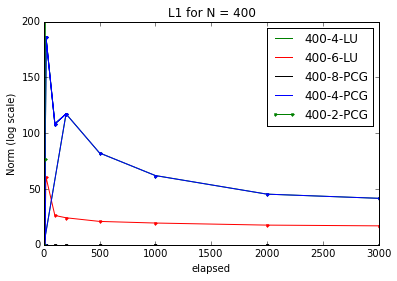

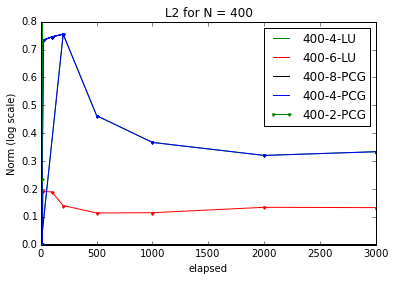

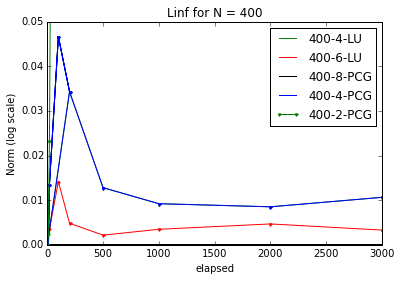

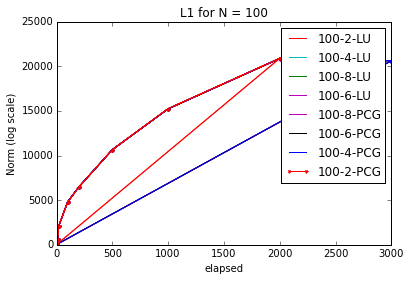

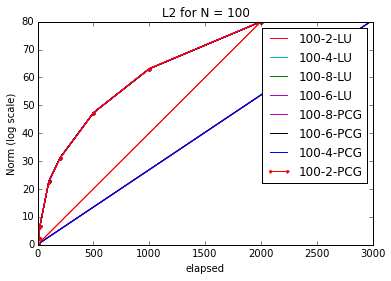

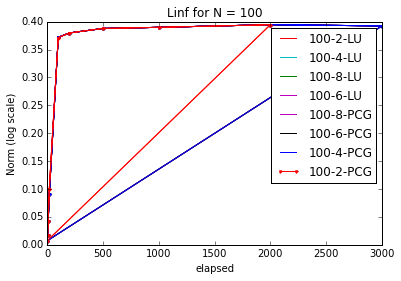

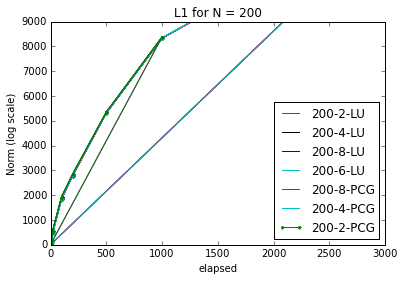

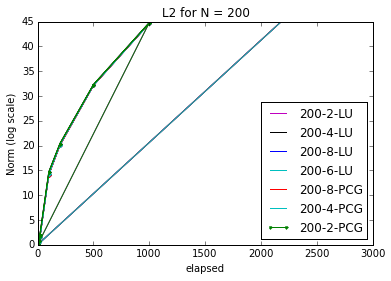

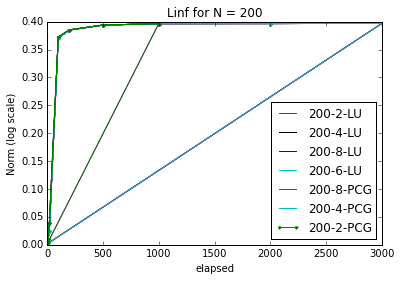

In [588]:
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import cycle
cycol = cycle('bgrcmk').next

print simulations

best_nx, best_sweeps = best_key.split('-')
temp_frame = dfC_final.query('(nx == {0}) & (sweeps == {1})'.format(best_nx, best_sweeps))
color = cycol()


graph_grids = []
best_key+=str('-LU')
print 'Best simulation key is : ', best_key
for key in simulations:
    if key != best_key:
        print key
        nx, sweeps, solvr = key.split('-')

        color = cycol()
        temp_frame = dfC_final.query('(nx == {0}) & (sweeps == {1})'.format(nx, sweeps))
        if nx not in graph_grids:
            print 'yay'
            graph_grids.append(nx)
            if int(nx)==100:
                grids_100_L1 = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 100', label=key)
                plt.ylabel('Norm (log scale)')
                plt.xlabel('Elapsed Time')
                grids_100_L1.set_xlabel('Norm (log scale)')                

                grids_100_L2 = temp_frame.plot('elapsed', 'L2', kind='line', ylim=0, c=color, marker='.',
                                               title='L2 for N = 100', label=key)
                plt.ylabel('Norm (log scale)')
                plt.xlabel('Elapsed Time')
                grids_100_L2.set_xlabel('Norm (log scale)')                

                grids_100_Linf = temp_frame.plot('elapsed', 'Linf', kind='line', ylim=0, c=color, marker='.',
                                                 title='Linf for N = 100', label=key)
                plt.ylabel('Norm (log scale)')
                plt.xlabel('Elapsed Time')
                grids_100_Linf.xaxis.set_label('Norm (log scale)')                


            if int(nx)==200:
#                 print '200 yay'
                grids_200_L1 = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 200', label=key) #, logy=True
                plt.ylabel('Norm (log scale)')
                plt.xlabel('Elapsed Time')
            
                grids_200_L2 = temp_frame.plot('elapsed', 'L2', kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 200', label=key) #, logy=True
                plt.ylabel('Norm (log scale)')
                plt.xlabel('Elapsed Time')
                
                grids_200_Linf = temp_frame.plot('elapsed', 'Linf', kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 200', label=key) #, logy=True
                plt.ylabel('Norm (log scale)')
                plt.xlabel('Elapsed Time')
                
            if int(nx)==400:
#                 print '400 yay'
                grids_400_L1 = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 400', label=key)
                plt.ylabel('Norm (log scale)')
                plt.xlabel('Elapsed Time')
            
                grids_400_L2 = temp_frame.plot('elapsed', 'L2', kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 400', label=key)
                plt.ylabel('Norm (log scale)')
                plt.xlabel('Elapsed Time')
                
                grids_400_Linf = temp_frame.plot('elapsed', 'Linf', kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 400', label=key)
                plt.ylabel('Norm (log scale)')
                plt.xlabel('Elapsed Time')
        else:
            if int(nx)==100:
#                 print 'eleeeeeeeeee yay'
                temp_frame.plot('elapsed', 'L1', ax = grids_100_L1, kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 100', label=key)
                temp_frame.plot('elapsed', 'L2', ax = grids_100_L2, kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 100', label=key)
                temp_frame.plot('elapsed', 'Linf', ax = grids_100_Linf, kind='line', ylim=0, c=color, marker='.', 
                                                title='Linf for N = 100', label=key)
            
                axes100 = plt.gca()
                # recompute the ax.dataLim
                axes100.relim()
                # update ax.viewLim using the new dataLim
                axes100.autoscale_view()
                plt.draw()

            if int(nx)==200:
                temp_frame.plot('elapsed', 'L1', ax = grids_200_L1, kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 200', label=key)
                axes200L1 = grids_200_L1.get_axes()
                # recompute the ax.dataLim
                axes200L1.relim()
                # update ax.viewLim using the new dataLim
                axes200L1.autoscale_view()
                plt.draw()
                
                
                temp_frame.plot('elapsed', 'L2', ax = grids_200_L2, kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 200', label=key)
                temp_frame.plot('elapsed', 'Linf', ax = grids_200_Linf, kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 200', label=key)
            if int(nx)==400:
                temp_frame.plot('elapsed', 'L1', ax = grids_400_L1, kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 400', label=key)
                temp_frame.plot('elapsed', 'L2', ax = grids_400_L2, kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 400', label=key)
                temp_frame.plot('elapsed', 'Linf', ax = grids_400_Linf, kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 400', label=key)

axplt = plt.gca()
axplt
grids_100_L1.xaxis.set_label('Norm (log scale)')                
plt.ylabel('Norm (log scale)')
plt.xlabel('Elapsed Time')
# plt.legend()
plt.show()
            

# Save out for Daniel

add the memory usage data and real world duration times

In [151]:
#what are the simulations we are concerned with?
temp_labels = []
for thing in np.unique(dfC_final['label']):
    print str(thing)
    temp_labels.append(str(thing))

# print temp_labels


with open('memory_peaks_LU.json') as ff_LU:
    memory_data_LU = json.load(ff_LU)
with open('memory_peaks_PCG.json') as ff_PCG:
    memory_data_PCG = json.load(ff_PCG)
    
print memory_data_LU #this is the memory data we will use for all simulations
print memory_data_PCG
print '-'*100
# print float(df[df['label'] == "a45690313727"]['duration'])


for index, row in dfC_final.iterrows():
    if row['solver']=="LU" and row['tolerance']==0.1:
        lbl = str(row['label'])
#         print row['nx']
#         print lbl
        dfC_final.loc[index, 'memory usage'] = memory_data_LU[str(row['nx'])]
        dfC_final.loc[index, 'real duration'] = float(df.query('(label=="{0}")'.format(lbl))['duration'])
    elif row['solver']=="PCG" and row['tolerance']==0.1:
        lbl = str(row['label'])
        dfC_final.loc[index, 'memory usage'] = memory_data_PCG[str(row['nx'])]
        dfC_final.loc[index, 'real duration'] = float(dfPCG.query('(label=="{0}")'.format(lbl))['duration'])
    elif row['solver']=="PCG" and row['tolerance']==0.001:
        lbl = str(row['label'])
        dfC_final.loc[index, 'memory usage'] = memory_data_PCG[str(row['nx'])]
        dfC_final.loc[index, 'real duration'] = float(dfPCG_tol_001.query('(label=="{0}")'.format(lbl))['duration'])

120707df6f2e
1b3f9740788f
1b69921762d7
2294ce8e0c73
2e8f28c2904c
3c08d6f123cc
3c366474738b
3ea82cfb13ea
43a9f66996e8
526ed7a0713d
5c4434ccd256
7a6c2016d64a
7c96995e7c0f
958114401cde
9a98c389d8c2
a45690313727
a47c4d5bffd5
abc377b4f395
ad4019c3836e
b2d08ea943af
b2dcac59614a
b87430153b0e
e294583f95a6
ea519a46fe59
f1c316514546
{u'200': 357.707031, u'100': 150.066406, u'50': 110.140625, u'400': 1120.996094}
{u'200': 223.636719, u'100': 121.109375, u'50': None, u'400': 607.679688}
----------------------------------------------------------------------------------------------------


In [153]:
dfC1_dropcol = dfC_final.drop('c_var_array', 1) #drop the array to save space
dfC1_dropcol.to_csv('andrey_plot_data3.csv') #save the file to email to daniel

This code will get a list of free energy values and a list of elapsed time values for a specific sumatra label

In [123]:
###FREE ENERGY MATH
results = {}
c_alpha = 0.3
c_beta = 0.7




kappa = 2.0
M = 5.0
c_0 = 0.5
epsilon = 0.01
rho_s = 5.0

def f_0(c):
    return rho_s*((c - c_alpha)**2)*((c_beta-c)**2)
# free energy
def f(c):
    return (f_0(c)+ .5*kappa*(c.grad.mag)**2)




###FREE ENERGY MATH ENDS

energyList = []
timeList = []
Lx=200.0
#This code will access every step file saved in the Data/[label] directory 


filepath = "/data/aem1/new1a/cluster-sumatra-sims/Data/43a9f66996e8"
#gets the last step file in the directory (hopefully at equillibrium)
#         file = os.listdir('Data/{0}'.format(label))[len(os.listdir('Data/{0}'.format(label)))-2] 
stepfiles = glob.glob('{0}/*.npz'.format(filepath)) #get the list of all step files for simulation
#         print stepfiles
fn_0 = np.load(stepfiles[0])
SimMesh = fp.PeriodicGrid2D(nx=fn['nx'], ny=fn['ny'], dx = Lx / fn['nx'], dy = Lx / fn['ny'])
cvar_array = fn_0['c_var_array']
c_var = fp.CellVariable(value = cvar_array, mesh = SimMesh)

for stpfile in stepfiles:
    fn = np.load(stpfile)
#                 print stpfile
    #do free enrgy math here

    cvar_array = fn['c_var_array']
    c_var[:] = cvar_array
    cells = fn['nx']*fn['ny']
    dx = Lx / fn['nx']
    dy = Lx / fn['ny']
    free_energy_array = f(c_var)
    free_energy_cellVolAvg = np.mean(free_energy_array)*cells*dx*dy
    energyList.append(free_energy_cellVolAvg)
    timeList.append(float(fn['elapsed']))
    
print energyList
print '-'*100

print timeList

[319.05536555635217, 318.96438404155111, 318.85827371179801, 318.71177373639324, 317.3219931305095, 316.22675804754704, 295.78674209013434, 293.44627548708797, 211.40914803231527, 208.41914842277987, 184.07819540377673, 157.6414742534354, 141.88608832893073, 136.77337503257573, 133.71312209978609, 127.58635844028647, 122.8374065325492, 119.16606229714193, 118.78040433709215, 114.84309746833861, 111.34382147809778, 108.24803669260983, 105.75239041730647, 103.71046239404524, 101.97686552768381, 100.41632806551529, 99.000944323339809, 98.062543186938484, 97.650657656399233, 96.338157774767453, 95.060383342577524, 93.778737345945359, 92.541863652252403, 91.316727231027372, 90.100423299725151, 88.968461413824443, 87.842955553658754, 86.74665883153709, 85.682141228050554, 84.712858378886253, 83.769491279435556, 82.894708924309612, 82.655783014582696, 82.08071595321239, 81.275738106363065, 80.509692134445601, 79.763652610028359, 79.035931322104034, 78.3409747692927, 77.660718477553502, 77.021

In [122]:
import matplotlib.pyplot as plt
plt.plot(timeList, energyList)
plt.show()

# Plot Norms for various sweeps 

to compare the Norms for various grid sizes at specific sweeps and elapsed time

# Free Energy Interpolation

For this section, we have to take the elapsed time and cvar from each step file, calculate the energy at that step, then interpolate the array of energies along with time. Save the intepolated function into the SUMATRA dataframe

In [88]:
import os
import numpy as np
from scipy import interpolate as scpinter

results = {}
c_alpha = 0.3
c_beta = 0.7
kappa = 2.0
# M = 5.0
# c_0 = 0.5
# epsilon = 0.01
rho_s = 5.0

def f_0(c):
    return rho_s*((c - c_alpha)**2)*((c_beta-c)**2)
# free energy
def f(c):
    return (f_0(c)+ .5*kappa*(c.grad.mag)**2)


def freeEnergyInterp(labels, dframe, Lx = 200.):
    test_dict = {}
    energyFunctions = []
    #This code will access every step file saved in the Data/[label] directory 
    for label in dframe['label']:
        e_elaps = []
        e_enrg = []
        dpath = str(df['datastore'][0]['parameters']['root'])
        dpath = dpath[:-13]
        filepath = os.path.join(dpath, label)
        #gets the last step file in the directory (hopefully at equillibrium)
#         file = os.listdir('Data/{0}'.format(label))[len(os.listdir('Data/{0}'.format(label)))-2] 
        stepfiles = glob.glob('{0}/*.npz'.format(filepath)) #get the list of all step files for simulation
#         print stepfiles
        if len(stepfiles)==0: 
            energyFunctions.append(None)
#             print 'nothing nothing'
        else:
            fn_0 = np.load(stepfiles[0])
            SimMesh = fp.PeriodicGrid2D(nx=fn_0['nx'], ny=fn_0['ny'], dx = Lx / fn_0['nx'], dy = Lx / fn_0['ny'])
            cvar_array = fn_0['c_var_array']
            c_var = fp.CellVariable(value = cvar_array, mesh = SimMesh)
            for stpfile in stepfiles:
                fn = np.load(stpfile)

                cvar_array = fn['c_var_array']
                c_var[:] = cvar_array
                cells = fn['nx']*fn['ny']
                dx = Lx / fn['nx']
                dy = Lx / fn['ny']
                free_energy_array = f(c_var)
                free_energy_cellVolAvg = np.mean(free_energy_array)*cells*dx*dy


                e_elaps.append(fn['elapsed'])
                e_enrg.append(free_energy_cellVolAvg)
        print 'e_elaps: ', len(e_elaps), '   e_enrg: ', len(e_enrg)
        eFunction = scpinter.interp1d(e_elaps, e_enrg, copy=False)
        energyFunctions.append(eFunction) #save a list of all the energy functions
        print ' '
        print '='*100
        print 'Number of energy functions: ', len(energyFunctions) 
        
        
        #svae values into a dictionary to figure out why norms are 0 for grids 400
        if label not in test_dict.keys():
            test_dict[label] = {'elapsed':e_elaps, 'energy':e_enrg}
            
            
            
    dframe['Free_Energy_Interpolated_Function'] = energyFunctions #add the list as a new column to the dataframe
    return test_dict
labels = dfC_final['label']
print labels
test_dict = freeEnergyInterp(labels, dfC_final)
#             data = {'cvar':fn['cvar'], 'freeEn':float(fn['f']), 'step':int(fn['steps']), 'elapsed':float(fn['time'])}
#     #         print type(data)
#     #         print type(str(fn['grid']))
#             results.update({str(fn['grid']):data})


0      ea519a46fe59
1      ea519a46fe59
2      ea519a46fe59
3      ea519a46fe59
4      ea519a46fe59
5      ea519a46fe59
6      a45690313727
7      a45690313727
8      a45690313727
9      a45690313727
10     a45690313727
11     a45690313727
12     a45690313727
13     a45690313727
14     a45690313727
15     5c4434ccd256
16     5c4434ccd256
17     5c4434ccd256
18     5c4434ccd256
19     5c4434ccd256
20     5c4434ccd256
21     5c4434ccd256
22     5c4434ccd256
23     5c4434ccd256
24     5c4434ccd256
25     1b69921762d7
26     1b69921762d7
27     1b69921762d7
28     1b69921762d7
29     1b69921762d7
           ...     
186    958114401cde
187    958114401cde
188    958114401cde
189    7a6c2016d64a
190    7a6c2016d64a
191    7a6c2016d64a
192    7a6c2016d64a
193    7a6c2016d64a
194    7a6c2016d64a
195    7a6c2016d64a
196    7a6c2016d64a
197    7a6c2016d64a
198    7a6c2016d64a
199    7c96995e7c0f
200    7c96995e7c0f
201    7c96995e7c0f
202    7c96995e7c0f
203    7c96995e7c0f
204    7c96995e7c0f


ValueError: total size of new array must be unchanged

# Figures of Merit

Now we need to use methods to add some figures of merit to the dataframes to compare the grids to the 400 grid

In [218]:
#add moose data as well
#This method takes any set of "ideal times" and compares the free energy values at those times for every simulation

ideal_times = []
for i in xrange(1, 1000): ideal_times.append(i)
# ideal_times = [1, 5, 10]
print ideal_times

def FreeEnergyCompare(dframe, ideal_times):
    L1Norms = [] #should these be dictionaries to match with the proper simulation label? 
    L2Norms = []
    LinfNorms = []
    N_Best = 0
    sweeps_Best = 0
    
    for row in dframe.iterrows():
        if row[1]['nx'] >= N_Best and row[1]['sweeps'] >= sweeps_Best:
            BestEnergyFunct = row[1]['Free_Energy_Interpolated_Function']
            N_Best = row[1]['nx']
            sweeps_Best = row[1]['sweeps']
    for row in dframe.iterrows():    
        efunction = row[1]['Free_Energy_Interpolated_Function']
        diff = np.absolute(efunction(ideal_times) - BestEnergyFunct(ideal_times))
        L1Norms.append(np.linalg.norm(diff,1)) 
        L2Norms.append(np.linalg.norm(diff,2)) 
        LinfNorms.append(np.linalg.norm(diff, np.inf)) 
    
    
    dframe['L1 Free Energy Norms'] = L1Norms
    dframe['L2 Free Energy Norms'] = L2Norms
    dframe['L-infinite Free Energy Norms'] = LinfNorms
    #Anushkas code
#     diff_50.append(np.absolute(y50x4[ideal_times] - y400x5[ideal_times]))
#     L1Norms.append(np.linalg.norm(diff_50,1))
#     L2Norms.append(np.linalg.norm(diff_50,2))
#     LinfNorms.append(np.linalg.norm(diff_50, np.inf))

FreeEnergyCompare(dfC_final, ideal_times)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

# Memory vs CPU time graphing

Now we will plot Memory Usage vs CPU for various grid sizes 

the color of the dot corresponds to how small the Norm for that grid size is (green = smallest)

In [37]:
float(dfC_final.query('(label=="d88bca02dcc7")').iloc[0]['L2 Free Energy Norms'])

4579282.3231437905

# Create a dataframe for the memory data to graph it

In [220]:
temp_labels = []
for thing in np.unique(dfC_final['label']):
    print str(thing)
    temp_labels.append(str(thing))
    
print temp_labels

1b69921762d7
2e8f28c2904c
3c08d6f123cc
3ea82cfb13ea
5c4434ccd256
9a98c389d8c2
a45690313727
e294583f95a6
['1b69921762d7', '2e8f28c2904c', '3c08d6f123cc', '3ea82cfb13ea', '5c4434ccd256', '9a98c389d8c2', 'a45690313727', 'e294583f95a6']


In [221]:
#what are the simulations we are concerned with?
sim_labels = temp_labels
dfMem = pandas.DataFrame(columns=['label','steps','sumatra duration', 'elapsed', 'nx', 'sweeps', 'memory usage', 'L1 Free Energy', 'L2 Free Energy', 'Linf Free Energy'])
rows = 0
data_dict = {} #the dictionary to which we will add data

with open('memory_peaks.json') as ff:
    memory_data = json.load(ff)
print memory_data #this is the memory data we will use for all simulations
    
for label in sim_labels:
#     print type(label)
#     label = str(label)
    temp_df = df.query('(label == "{0}")'.format(label))
    #build the dictionary to add to the memory dataframe
    data_dict['sumatra duration'] = float(temp_df['duration'])
    data_dict['label'] = label   
    data_dict['steps'] = 0
    data_dict['elapsed'] = 0
    data_dict['nx'] = int(dfC_final.query('(label=="{0}")'.format(label)).iloc[0]['nx'])
    data_dict['sweeps'] = int(dfC_final.query('(label=="{0}")'.format(label)).iloc[0]['sweeps'])
    data_dict['memory usage'] = memory_data[str(data_dict['nx'])]
    data_dict['L1 Free Energy'] = float(dfC_final.query('(label=="{0}")'.format(label)).iloc[0]['L1 Free Energy Norms'])
    data_dict['L2 Free Energy'] = float(dfC_final.query('(label=="{0}")'.format(label)).iloc[0]['L2 Free Energy Norms'])
    data_dict['Linf Free Energy'] = float(dfC_final.query('(label=="{0}")'.format(label)).iloc[0]['L-infinite Free Energy Norms'])
    
    dfMem.loc[rows]=data_dict
    rows +=1
    
# dfMem['label'] = sim_labels
dfMem

{u'200': 357.707031, u'100': 150.066406, u'50': 110.140625, u'400': 1120.996094}


,label,steps,sumatra duration,elapsed,nx,sweeps,memory usage,L1 Free Energy,L2 Free Energy,Linf Free Energy
0,1b69921762d7,0.0,112169.970555,0.0,200.0,2.0,357.707031,3.011823e+06,3.456383e+05,84943.977323
1,2e8f28c2904c,0.0,8515.319348,0.0,100.0,8.0,150.066406,6.673101e+07,3.166989e+06,477574.068436
2,3c08d6f123cc,0.0,6651.941850,0.0,100.0,6.0,150.066406,6.664747e+07,3.146242e+06,448227.098161
3,3ea82cfb13ea,0.0,91237.327753,0.0,200.0,8.0,357.707031,0.000000e+00,0.000000e+00,0.000000
4,5c4434ccd256,0.0,6814.065737,0.0,100.0,4.0,150.066406,6.594142e+07,3.065956e+06,438330.544051
5,9a98c389d8c2,0.0,80378.187434,0.0,200.0,6.0,357.707031,1.623186e+06,2.067870e+05,87884.427960
6,a45690313727,0.0,11980.867890,0.0,100.0,2.0,150.066406,6.451336e+07,2.963258e+06,483094.675927
7,e294583f95a6,0.0,123649.590158,0.0,200.0,4.0,357.707031,1.545904e+06,1.997837e+05,63599.018361


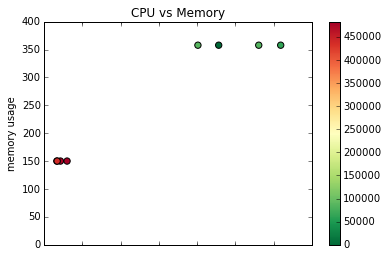

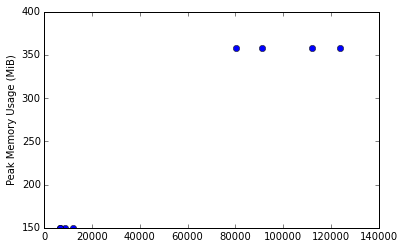

Text(0.5,7.2,u'Simulation Duration (s)')


In [278]:
memory_plot = dfMem.plot('sumatra duration', 'memory usage', kind='scatter',ylim=0, title='CPU vs Memory', c=dfMem['Linf Free Energy'], cmap='RdYlGn_r', s=40)

fig = plt.figure()
axPlot = fig.add_subplot(111, axes = memory_plot.axes)

axPlot.plot(dfMem['sumatra duration'], dfMem['memory usage'],'o')
plt.ylabel('Peak Memory Usage (MiB)')
memory_plot.set_xlabel('Simulation Duration (s)')
memory_plot.axes.set_xlabel('Simulation Duration (s)')
plt.subplots_adjust(bottom=0.15)
# plt.gca().tight_layout()
plt.show()
print memory_plot.axes.xaxis.label
# Energy_N100_L1_graph = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.', 
#                                                title='Free Energy L1 for N = 100', label=key)

In [267]:
label = 'fafbeb433621'
df.query('(label == "{0}")'.format(label))

with open('memory_peaks.json') as ff:
    memory_data = json.load(ff)
    print memory_data['100']

150.066406
